In [498]:
import pandas as pd
import numpy as np
df_train = pd.read_csv('train.csv',index_col=0)
df_test = pd.read_csv('test.csv',index_col=0)

class etl:
    def __init__(self,data,training=True,split_cities=True):
        """ETL use cases: training data, making predictions and training on the context of different cities"""
        self.data = data
        self.training = training
        self.split = 0.8
        self.split_cities = split_cities
        
    def transform(self):
        """forward fill null values and drop date/year columns"""
        iq = self.data[self.data['city']=='iq'].sort_values(by='week_start_date',ascending=True)
        sj = self.data[self.data['city']=='sj'].sort_values(by='week_start_date',ascending=True)
        sj.fillna(method='ffill', inplace=True)
        iq.fillna(method='ffill', inplace=True)
        self.data = pd.concat([sj,iq],axis=0)
        self.data.drop(['week_start_date','year'],axis=1,inplace=True)
        self.data = self.format_city()
        return self.data
    def format_city(self):
        """convert the city into a machine readible variable"""
        self.data['city'] = self.data['city'].apply(lambda x: 1 if x=='sj' else 0)
        return self.data
    
    def split_data(self,df):
        """split the data into train and test sets"""
        mask = np.random.rand(len(df))<self.split
        train = df[mask]
        test = df[~mask]
        return train,test
    
    def load(self):
        data = self.transform()
        if self.training:
            if self.split_cities:
                sj = data[data['city']==1].drop('city',axis=1)
                iq = data[data['city']==0].drop('city',axis=1)
                sj_train,sj_test = self.split_data(sj)
                iq_train,iq_test = self.split_data(iq)
                return sj_train,sj_test,iq_train,iq_test
            else:
                return self.split_data(data)
        else:
            if self.split_cities:
                sj = data[data['city']==1].drop('city',axis=1)
                iq = data[data['city']==0].drop('city',axis=1)
                return sj,iq
            else:
                return data
    
sj_train,sj_test,iq_train,iq_test = etl(df_train).load()
train, test = etl(df_train,split_cities=False).load()
train_test_pairs = [(sj_train,sj_test),(iq_train,iq_test),(train,test)]
features = [j for j in df_train.columns if j not in ['week_start_date','year','city']]

# Run several experiments:
* Linear models for each city
* Linear models for the cities combined
* Use recursive feature elimination to find the best combination of features.

We need a baseline of what "bad a bad model" would look like. To do this, we should take the actual predicted values and find the error for three cases
* If our model predicted only zero
* If our model predicted only the mean daily number of cases
* If our model predicted only the median daily number of cases

What would the mean absolute error be for each of these cases? Knowing this, if we look at what our models predict we can examine

In [8]:
from sklearn.metrics import mean_absolute_error
def scores_of_bad_models(df):
    predict_median = [np.median(df['total_cases']) for i in range(len(df))]
    predict_mean = [df['total_cases'].mean() for i in range(len(df))]
    predict_zero = [0 for i in range(len(df))]
    predict_mean_error = round(mean_absolute_error(df['total_cases'],predict_mean),2)
    predict_zero_error = round(mean_absolute_error(df['total_cases'],predict_zero),2)
    predict_median_error = round(mean_absolute_error(df['total_cases'],predict_median),2)
    return predict_mean_error,predict_zero_error,predict_median_error

datasets = [df_train,df_train[df_train['city']=='sj'],df_train[df_train['city']=='iq']]
scores = {}
for i in range(3):
    if i==0:
        name = 'both'
    elif i==1:
        name = 'sj'
    elif i==2:
        name = 'iq'
    scores[name] = [*scores_of_bad_models(datasets[i])]
    
scores = pd.DataFrame(scores).transpose()
scores.columns = ['predict_mean','predict_zero','predict_median']
scores['min'] = scores.apply(lambda x: x.min(),axis=1)
scores.index.name='cities'
scores.to_csv('scores_of_base_models.csv')
scores

,predict_mean,predict_zero,predict_median,min
cities,,,,
both,23.00,24.68,19.88,19.88
sj,28.35,34.18,24.71,24.71
iq,6.68,7.57,6.05,6.05


Using our lowest error for this, we can tell that any useful model will be making predictions with an mean absolute error below 19.8. Otherwise our model is performaning no better than just predicting a constant value. 

The strategy is that we loop through the features, and on each one we run the negative binomial distribution versus the `total_cases`. Searching for the best model parameters, we regard any feature performs worse than our median prediction model and disregard the feature.

In [434]:
from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf
import statsmodels.api as sm
def negative_binomial_models(train,test,city,param_grid,*features,return_model=False,return_predictions=False):
    # Step 1: specify the form of the model
    model_formula = "total_cases ~"
    for index,f in enumerate([j for j in features if j!='total_cases']):
        if index==0:
            model_formula = model_formula+" {}".format(f)
        else:
            model_formula = model_formula+" + {}".format(f)
    best_alpha = None
    best_score = 1000  
    # Step 2: Find the best hyper parameter, alpha
    print('model_formula: ',model_formula)
    for alpha in param_grid:
        model = smf.glm(formula=model_formula,data=train,family=sm.families.NegativeBinomial(alpha=alpha))
        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)
        if score < best_score:
            best_alpha = alpha
            best_score = score
    # Step 3: refit on entire dataset
    if return_model:
        full_dataset = pd.concat([train, test])
        model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))
        return model.fit()
    
    else:
        metrics = {'city':city,'score_test':best_score,'alpha':best_alpha}
        if return_predictions:
            metrics['predictions_test']=predictions
            predictions_train = results.predict(train).astype(int)
            metrics['predictions_train']=predictions_train
            metrics['score_train'] = eval_measures.meanabs(predictions_train, train.total_cases)
        if len(feature)==1:
            metrics['features']=features[0]
        else:
            print('length of features: ',len(features))
            metrics['features']=len(features)
        return metrics

In [86]:
def feature_tests(param_grid):
    results = []
    for feature in features:
        for element in range(3):
            trainset = train_test_pairs[element][0][[feature,'total_cases']]
            testset = train_test_pairs[element][1][[feature,'total_cases']]
            if element==0:
                city = 'sj'
            elif element==1:
                city = 'iq'
            elif element==2:
                city = 'both'
            result = negative_binomial_models(trainset,testset,city,param_grid,*[feature])
            results.append(result)
    return pd.DataFrame(results)

In [87]:
#try:
#    feature_results = pd.read_csv('linear_model_results.csv',index_col=0)
#except:
lower=0.1
upper=500
param_grid = [round(j,4) for j in np.arange(lower,upper,0.5)]
feature_results = feature_tests(param_grid)
feature_results.to_csv('linear_model_results2.csv')
feature_results

,city,score,alpha,features
0,sj,25.727811,5.1,weekofyear
1,iq,6.727273,1.1,weekofyear
2,both,19.745318,0.6,weekofyear
3,sj,27.804734,0.1,ndvi_ne
4,iq,6.709091,0.1,ndvi_ne
...,...,...,...,...
58,iq,6.363636,0.1,station_min_temp_c
59,both,19.044944,12.6,station_min_temp_c
60,sj,27.455621,1.1,station_precip_mm
61,iq,6.745455,0.1,station_precip_mm


In [4]:
import pandas as pd
pd.read_csv('linear_model_results2.csv')['alpha'].max()

109.6

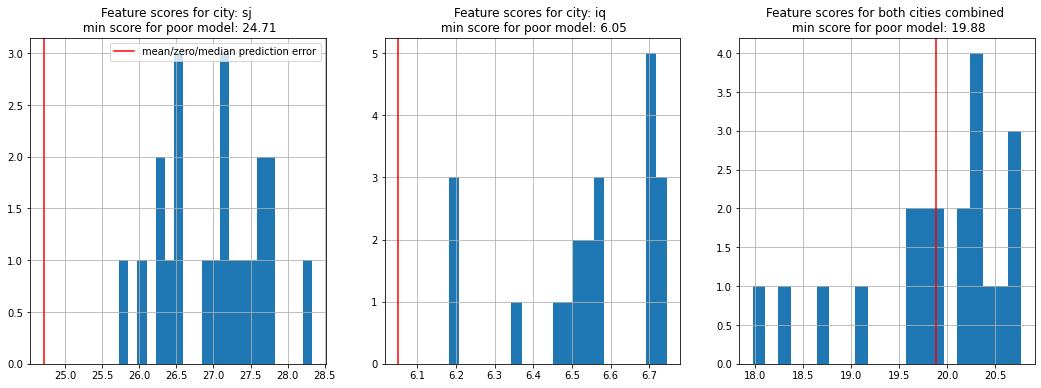

In [96]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.title('Feature scores for city: sj \n min score for poor model: {}'.format(scores.loc['sj']['min']))
feature_results[feature_results['city']=='sj']['score'].hist(bins=len(features))
plt.axvline(scores.loc['sj']['min'],label='mean/zero/median prediction error',color='red')
plt.legend()
plt.subplot(1,3,2)
plt.title('Feature scores for city: iq \n min score for poor model: {}'.format(scores.loc['iq']['min']))
feature_results[feature_results['city']=='iq']['score'].hist(bins=len(features))
plt.axvline(scores.loc['iq']['min'],label='mean/zero/median prediction error',color='red')
#plt.legend()
plt.subplot(1,3,3)
plt.title('Feature scores for both cities combined \n min score for poor model: {}'.format(scores.loc['both']['min']))
feature_results[feature_results['city']=='both']['score'].hist(bins=len(features))
plt.axvline(scores.loc['both']['min'],label='mean/zero/median prediction error',color='red')
#plt.legend()
plt.show()

The previous strategy used a comparison of every feature versus the target, and tuned the alpha parameter of the negative binomial distribution, we can draw one of two conclusions

* For seperating the models by city, the features versus the target alone perform no better than predicting the mean, median or zero for the target variable for most cases.

* Either the features some features are useless or they should be combined non-linearly.

The following features performed better than simply using the mean, median or zero to make predictions.

In [396]:
min_scores = pd.DataFrame(scores['min']).reset_index()
feature_results_joined = feature_results.merge(min_scores,left_on='city',right_on='cities')[['features','score','cities','alpha','min']]
key_features = feature_results_joined[feature_results_joined['score']<=feature_results_joined['min']]
key_features_list = list(set(key_features['features']))
key_features

,features,score,cities,alpha,min
42,weekofyear,19.745318,both,0.6,19.88
48,reanalysis_air_temp_k,18.640449,both,0.1,19.88
51,reanalysis_max_air_temp_k,19.831461,both,0.1,19.88
52,reanalysis_min_air_temp_k,17.973783,both,7.6,19.88
54,reanalysis_relative_humidity_percent,19.685393,both,0.1,19.88
57,reanalysis_tdtr_k,18.318352,both,13.6,19.88
59,station_diur_temp_rng_c,19.704120,both,0.1,19.88
61,station_min_temp_c,19.044944,both,12.6,19.88


Thus we can suggest that these are the most useful sets of features for prediction.

In [440]:
import matplotlib.pyplot as plt
def get_model_results(trainset,testset,city,param_grid,*features):
    results = negative_binomial_models(trainset,testset,city,param_grid,*features,
                                       return_model=False,return_predictions=True)
    testset['predictions'] = results['predictions_test']
    trainset['predictions'] = results['predictions_train']
    
    results_data_test = testset[['total_cases','predictions']].join(df_train[['city','week_start_date']])
    results_data_test['label'] = 'test'
    results_data_test['score'] = results['score_test']
    
    results_data_train = trainset[['total_cases','predictions']].join(df_train[['city','week_start_date']])
    results_data_train['label'] = 'train'
    results_data_train['score'] = results['score_train']
    
    results_data = pd.concat([results_data_train,results_data_test],axis=0)
    results_data['alpha'] = results['alpha']
    results_data['features'] = results['features']
    results_data['city'] = results['city']
    return results_data

def plot_feature_timeseries(data,title):
    time_series = data[['city','week_start_date','total_cases','predictions']]
    time_series['week_start_date'] = pd.to_datetime(time_series['week_start_date'])
    time_series.set_index('week_start_date',inplace=True)
    plt.figure(figsize=(18,8))
    plt.title(title,fontsize=20)
    plt.plot(time_series['total_cases'],label='cases',color='blue')
    plt.plot(time_series['predictions'],label='predictions',color='red')
    plt.legend(fontsize=20)
    plt.ylabel(feature,fontsize=20)
    plt.xticks(fontsize=20)
    plt.show()

output = pd.DataFrame()   
for n in range(len(train_test_pairs)):
    for feature_set in [key_features_list,features]:
        trainset = train_test_pairs[n][0][feature_set]
        testset = train_test_pairs[n][1][feature_set]
        if n==0:
            city='sj'
        elif n==1:
            city='iq'
        elif n==2:
            city='both'
        _ = get_model_results(trainset,testset,city,param_grid[:50],*feature_set)
        output = pd.concat([_,output],axis=0)

model_formula:  total_cases ~ weekofyear + reanalysis_min_air_temp_k + station_min_temp_c + reanalysis_max_air_temp_k + reanalysis_tdtr_k + station_diur_temp_rng_c + reanalysis_air_temp_k + reanalysis_relative_humidity_percent
length of features:  9
model_formula:  total_cases ~ weekofyear + ndvi_ne + ndvi_nw + ndvi_se + ndvi_sw + precipitation_amt_mm + reanalysis_air_temp_k + reanalysis_avg_temp_k + reanalysis_dew_point_temp_k + reanalysis_max_air_temp_k + reanalysis_min_air_temp_k + reanalysis_precip_amt_kg_per_m2 + reanalysis_relative_humidity_percent + reanalysis_sat_precip_amt_mm + reanalysis_specific_humidity_g_per_kg + reanalysis_tdtr_k + station_avg_temp_c + station_diur_temp_rng_c + station_max_temp_c + station_min_temp_c + station_precip_mm


/var/folders/jl/97zzvf352gg0qn93kb33f4th0000gn/T/ipykernel_1259/2929938516.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testset['predictions'] = results['predictions_test']
/var/folders/jl/97zzvf352gg0qn93kb33f4th0000gn/T/ipykernel_1259/2929938516.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainset['predictions'] = results['predictions_train']


length of features:  22
model_formula:  total_cases ~ weekofyear + reanalysis_min_air_temp_k + station_min_temp_c + reanalysis_max_air_temp_k + reanalysis_tdtr_k + station_diur_temp_rng_c + reanalysis_air_temp_k + reanalysis_relative_humidity_percent
length of features:  9
model_formula:  total_cases ~ weekofyear + ndvi_ne + ndvi_nw + ndvi_se + ndvi_sw + precipitation_amt_mm + reanalysis_air_temp_k + reanalysis_avg_temp_k + reanalysis_dew_point_temp_k + reanalysis_max_air_temp_k + reanalysis_min_air_temp_k + reanalysis_precip_amt_kg_per_m2 + reanalysis_relative_humidity_percent + reanalysis_sat_precip_amt_mm + reanalysis_specific_humidity_g_per_kg + reanalysis_tdtr_k + station_avg_temp_c + station_diur_temp_rng_c + station_max_temp_c + station_min_temp_c + station_precip_mm
length of features:  22
model_formula:  total_cases ~ weekofyear + reanalysis_min_air_temp_k + station_min_temp_c + reanalysis_max_air_temp_k + reanalysis_tdtr_k + station_diur_temp_rng_c + reanalysis_air_temp_k + r

In [441]:
output

,total_cases,predictions,city,week_start_date,label,score,alpha,features
1,5,25,both,NaN,train,18.842954,3.0,22
2,4,38,both,NaN,train,18.842954,3.0,22
3,3,33,both,NaN,train,18.842954,3.0,22
5,2,28,both,NaN,train,18.842954,3.0,22
6,4,33,both,NaN,train,18.842954,3.0,22
...,...,...,...,...,...,...,...,...
922,10,12,sj,NaN,test,32.972826,3.0,9
923,9,16,sj,NaN,test,32.972826,3.0,9
928,1,14,sj,NaN,test,32.972826,3.0,9
932,3,12,sj,NaN,test,32.972826,3.0,9


In [438]:
city='sj'
no_features=8

import matplotlib.pyplot as plt
def plot_feature_timeseries(data,title):
    time_series = data[['city','week_start_date','total_cases','predictions']]
    time_series['week_start_date'] = pd.to_datetime(time_series['week_start_date'])
    time_series.set_index('week_start_date',inplace=True)
    #plt.figure(figsize=(18,8))
    plt.title(title,fontsize=20)
    plt.plot(time_series['total_cases'],label='cases',color='blue')
        plt.plot(time_series['predictions'],label='predictions',color='red')
    else:
        for city in ['c']
    plt.legend(fontsize=12)
    plt.ylabel('cases',fontsize=12)
    plt.xticks(fontsize=12,rotation=45)

def plot_results(df_train,df_test,no_features,city):
    #plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    score_test = round(list(df_test['score'])[0],3)
    label_test = 'test set citiy: {} \n MAE: {} features: {}'.format(city,score_test,no_features)
    plot_feature_timeseries(df_test,label_test)

    plt.subplot(1,2,2)
    score_train = round(list(df_train['score'])[0],3)
    label_train = 'train set citiy: {} \n MAE: {} features: {}'.format(city,score_train,no_features)
    plot_feature_timeseries(df_train,label_train)
    plt.show()

In [493]:
def negative_binmoial_model(train,test,param_grid,city,*features,return_predictions=False):
    model_formula = "total_cases ~"
    for index,f in enumerate([j for j in features if j!='total_cases']):
        if index==0:
            model_formula = model_formula+" {}".format(f)
        else:
            model_formula = model_formula+" + {}".format(f)
    #print('model_formula: ',model_formula)
    best_alpha = None
    best_score = 1000  
    # Step 2: Find the best hyper parameter, alpha
    for alpha in param_grid:
        model = smf.glm(formula=model_formula,data=train,family=sm.families.NegativeBinomial(alpha=alpha))
        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)
        if score < best_score:
            best_alpha = alpha
            best_score = score
    best_model = smf.glm(formula=model_formula,data=train,family=sm.families.NegativeBinomial(alpha=best_alpha))
    best_results = best_model.fit()
    predictions_test = best_results.predict(test).astype(int)
    predictions_train = best_results.predict(train).astype(int)
    score_test = eval_measures.meanabs(predictions_test, test.total_cases)
    score_train = eval_measures.meanabs(predictions_train, train.total_cases)
    metrics = {'features':len(features),'city':city,'best_alpha':best_alpha,'mae_test':score_test,'mae_train':score_train}
    return metrics

In [499]:
output = []  
param_grid = np.arange(0.1,4,0.01)
for n in range(len(train_test_pairs)):
    for feature_set in [key_features_list,features]:
        if 'total_cases' not in feature_set:
            feature_set = list(feature_set) + ['total_cases']
        trainset = train_test_pairs[n][0][feature_set]
        testset = train_test_pairs[n][1][feature_set]
        if n==0:
            city='sj'
        elif n==1:
            city='iq'
        elif n==2:
            city='both'
        model_performance = negative_binmoial_model(trainset,testset,param_grid[:10],city,*feature_set)
        output.append(model_performance)
pd.DataFrame(output)

,features,city,best_alpha,mae_test,mae_train
0,9,sj,0.10,24.546798,26.432469
1,22,sj,0.11,23.492611,25.542974
2,9,iq,0.16,6.884211,6.000000
3,22,iq,0.10,7.136842,5.905882
4,9,both,0.17,19.037975,19.056140
5,22,both,0.10,18.284810,18.690351


It seems that using the key features tends to produce better results.

/var/folders/jl/97zzvf352gg0qn93kb33f4th0000gn/T/ipykernel_1259/4097428777.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testset['predictions']=predictions_test
/var/folders/jl/97zzvf352gg0qn93kb33f4th0000gn/T/ipykernel_1259/4097428777.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testset['score']=score_test
/var/folders/jl/97zzvf352gg0qn93kb33f4th0000gn/T/ipykernel_1259/4097428777.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

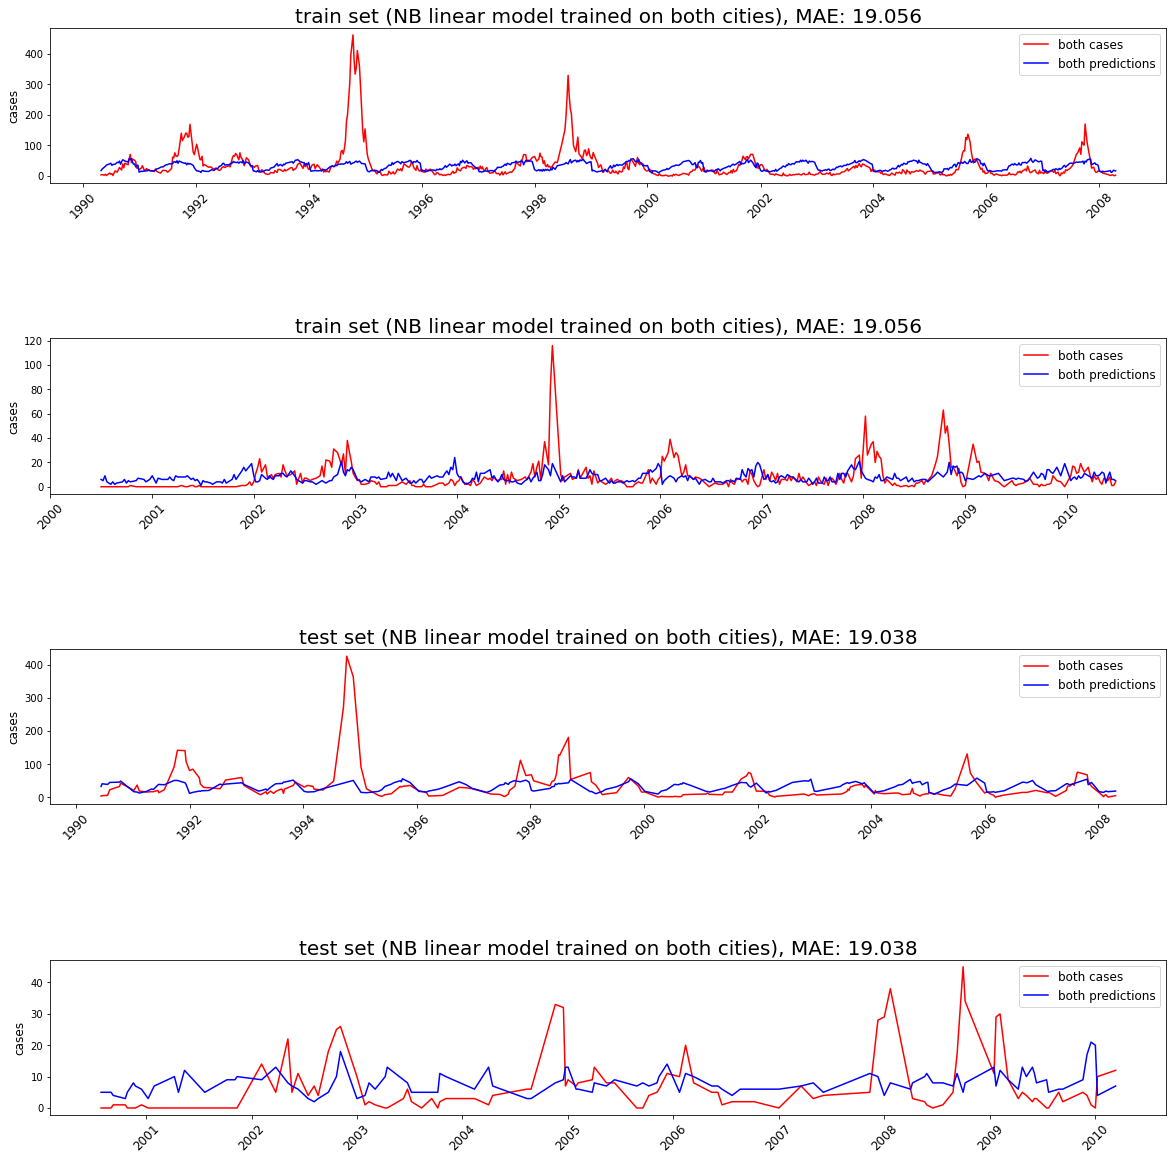

In [503]:
best_alpha = 0.17
n=2
trainset = train[key_features_list]
testset = test[key_features_list]
model_formula = 'total_cases ~ weekofyear + reanalysis_min_air_temp_k + station_min_temp_c + \
reanalysis_max_air_temp_k + reanalysis_tdtr_k + station_diur_temp_rng_c + reanalysis_air_temp_k + \
reanalysis_relative_humidity_percent'
best_results = smf.glm(formula=model_formula,data=trainset,family=sm.families.NegativeBinomial(alpha=best_alpha))
best_results = best_results.fit()
predictions_test = best_results.predict(testset).astype(int)
predictions_train = best_results.predict(trainset).astype(int)
score_test = eval_measures.meanabs(predictions_test, test.total_cases)
score_train = eval_measures.meanabs(predictions_train, train.total_cases)
testset['predictions']=predictions_test
testset['score']=score_test
testset = testset[['total_cases','predictions']].join(df_train[['city','week_start_date']])
trainset['predictions']=predictions_train
trainset['score']=round(score_train,3)
trainset = trainset[['total_cases','predictions']].join(df_train[['city','week_start_date']])

def plot_feature_timeseries(data,title):
    time_series = data[['city','week_start_date','total_cases','predictions']]
    time_series['week_start_date'] = pd.to_datetime(time_series['week_start_date'])
    time_series.set_index('week_start_date',inplace=True)
    plt.title(title,fontsize=20)
    colors = ['blue','red','green','black']
    plt.plot(time_series['total_cases'],label='{} cases'.format(city),color='red')
    plt.plot(time_series['predictions'],label='{} predictions'.format(city),color='blue')
    plt.legend(fontsize=12)
    plt.ylabel('cases',fontsize=12)
    plt.xticks(fontsize=12,rotation=45)

plt.figure(figsize=(20,20))
plt.subplot(4,1,1)
plot_feature_timeseries(trainset[trainset['city']=='sj'],'train set (NB linear model trained on both cities), MAE: {}'.format(round(score_train,3)))
plt.subplot(4,1,2)
plot_feature_timeseries(trainset[trainset['city']=='iq'],'train set (NB linear model trained on both cities), MAE: {}'.format(round(score_train,3)))
plt.subplot(4,1,3)
plot_feature_timeseries(testset[testset['city']=='sj'],'test set (NB linear model trained on both cities), MAE: {}'.format(round(score_test,3)))
plt.subplot(4,1,4)
plot_feature_timeseries(testset[testset['city']=='iq'],'test set (NB linear model trained on both cities), MAE: {}'.format(round(score_test,3)))
plt.subplots_adjust(hspace=1)
plt.show()
